In [12]:
import numpy as np
from movement.io import load_poses
import matplotlib.pyplot as plt
import json
from scipy.signal import welch
from movement import sample_data
from movement.filtering import filter_by_confidence, interpolate_over_time
from movement.kinematics import compute_velocity
from movement.filtering import (
    interpolate_over_time,
    rolling_filter,
    savgol_filter,
)
import xarray as xr
from movement.kinematics import (
    compute_forward_vector,
    compute_forward_vector_angle,
)
from movement.plots import plot_centroid_trajectory
from movement.utils.vector import cart2pol, pol2cart
import os
import glob
import pandas as pd
%matplotlib inline

In [2]:
def plot_raw_and_smooth_timeseries_and_psd(
    ds_raw,
    ds_smooth,
    individual=None,
    keypoint="center",
    space="x",
    time_range=None,
):
    
    # If no individual is specified, use the first one
    if individual is None:
        individual = ds_raw.individuals[0]
    # If no time range is specified, plot the entire time series
    if time_range is None:
        time_range = slice(0, ds_raw.time[-1])

    selection = {
        "time": time_range,
        "individuals": individual,
        "keypoints": keypoint,
        "space": space,
    }

    fig, ax = plt.subplots(2, 1, figsize=(10, 6))

    for ds, color, label in zip(
        [ds_raw, ds_smooth], ["k", "r"], ["raw", "smooth"], strict=False
    ):
        # plot position time series
        pos = ds.position.sel(**selection)
        ax[0].plot(
            pos.time,
            pos,
            color=color,
            lw=2,
            alpha=0.7,
            label=f"{label} {space}",
        )

        # interpolate data to remove NaNs in the PSD calculation
        pos_interp = interpolate_over_time(pos, fill_value="extrapolate")

        # compute and plot the PSD
        freq, psd = welch(pos_interp, fs=ds.fps, nperseg=256)
        ax[1].semilogy(
            freq,
            psd,
            color=color,
            lw=2,
            alpha=0.7,
            label=f"{label} {space}",
        )

    ax[0].set_ylabel(f"{space} position (px)")
    ax[0].set_xlabel("Time (s)")
    ax[0].set_title("Time Domain")
    ax[0].legend()

    ax[1].set_ylabel("PSD (px$^2$/Hz)")
    ax[1].set_xlabel("Frequency (Hz)")
    ax[1].set_title("Frequency Domain")
    ax[1].legend()

    plt.tight_layout()
    fig.show()

def ensure_da(arr):
    return arr if hasattr(arr, "plot") else xr.DataArray(arr)

def get_position_values(ds, space):
    space_vals_arr = ds.sel(space=space)
    space_vals = space_vals_arr.values
    space_vals = space_vals.flatten()
    return space_vals

def calculate_hd(position):
    # Method 1: Orthogonal between left and right ear
    hd_orth_ears = compute_forward_vector_angle(
            position,
            left_keypoint="left_ear",
            right_keypoint="right_ear",
            # Optional parameters:
            reference_vector=(1, 0),  # positive x-axis
            camera_view="top_down",
            in_degrees=False,  # set to True for degrees
    )

    # Method 2: Headcap to midpoint of ears
    midpoint_ears = position.sel(keypoints=["left_ear", "right_ear"]).mean(dim="keypoints")

    headcap  = position.sel(keypoints="headcap", drop=True)
    headcap_to_midpoint = headcap - midpoint_ears
    hd_cap_mp_polar = cart2pol(headcap_to_midpoint)
    hd_cap_mp = hd_cap_mp_polar.sel(space_pol="phi")
    hd_cap_mp = hd_cap_mp.values.flatten()

    # Method 3: Center to midpoint
    head_to_center = headcap - position.sel(keypoints="center")
    hd_cap_center_polar = cart2pol(head_to_center)
    hd_cap_center = hd_cap_center_polar.sel(space_pol="phi")
    hd_cap_center = hd_cap_center.values.flatten()

    return hd_orth_ears, hd_cap_mp, hd_cap_center


def plot_polar_histogram(da, bin_width_deg=15, ax=None):
    """Plot a polar histogram of the data in the given DataArray.

    Parameters
    ----------
    da : xarray.DataArray
        A DataArray containing angle data in radians.
    bin_width_deg : int, optional
        Width of the bins in degrees.
    ax : matplotlib.axes.Axes, optional
        The axes on which to plot the histogram.

    """
    if not hasattr(da, "plot"):
        da = xr.DataArray(da)
    n_bins = int(360 / bin_width_deg)

    if ax is None:
        fig, ax = plt.subplots(  # initialise figure with polar projection
            1, 1, figsize=(5, 5), subplot_kw={"projection": "polar"}
        )
    else:
        fig = ax.figure  # or use the provided axes

    # plot histogram using xarray's built-in histogram function
    da.plot.hist(
        bins=np.linspace(-np.pi, np.pi, n_bins + 1), ax=ax, density=True
    )

    # axes settings
    ax.set_theta_direction(-1)  # theta increases in clockwise direction
    ax.set_theta_offset(0)  # set zero at the right
    ax.set_xlabel("")  # remove default x-label from xarray's plot.hist()

    # set xticks to match the phi values in degrees
    n_xtick_edges = 9
    ax.set_xticks(np.linspace(0, 2 * np.pi, n_xtick_edges)[:-1])
    xticks_in_deg = (
        list(range(0, 180 + 45, 45)) + list(range(0, -180, -45))[-1:0:-1]
    )
    ax.set_xticklabels([str(t) + "\N{DEGREE SIGN}" for t in xticks_in_deg])

    return fig, ax

In [5]:
d = 1
tr = 7
if d == 1:
    folder_directory = r"D:\Spatiotemporal_task\derivatives\sub-002_id-1U\ses-01_date-02072025\all_trials\analysis\spatial_behav_data\XY_and_HD\inference_results"
    output_folder = r"D:\Spatiotemporal_task\derivatives\sub-002_id-1U\ses-01_date-02072025\all_trials\analysis\spatial_behav_data"
    trial_numbers = np.arange(1,9)
    name_structure = '1U_02072025.h5'
elif d == 2:
    folder_directory = r"D:\Spatiotemporal_task\derivatives\sub-002_id-1U\ses-02_date-03072025\all_trials\analysis\spatial_behav_data\XY_and_HD\inference_results"
    output_folder = r"D:\Spatiotemporal_task\derivatives\sub-002_id-1U\ses-02_date-03072025\all_trials\analysis\spatial_behav_data"
    trial_numbers = np.arange(4,10)
    name_structure = '_1U_July_3_'

frame_rate = 30



In [21]:
if d == 1:
    file_path = f"{folder_directory}\\T{tr}_{name_structure}"
elif d == 2:
    pattern = os.path.join(folder_directory, f"{name_structure}T{tr}_*.h5")
    matches = glob.glob(pattern)
    file_path = matches[0]

# --------- Loading data --------
ds = load_poses.from_sleap_file(file_path, fps=frame_rate)
position = ds.position 

if d == 1:
    file_path = f"{folder_directory}\\T{tr}_{name_structure}"
elif d == 2:
    pattern = os.path.join(folder_directory, f"{name_structure}T{tr}_*.h5")
    matches = glob.glob(pattern)
    file_path = matches[0]

# --------- Loading data --------
ds = load_poses.from_sleap_file(file_path, fps=frame_rate)
position = ds.position

2025-07-21 12:08:08.814 | WARNING  | movement.io.load_poses:_ds_from_sleap_analysis_file:486 - Could not find SLEAP Track in D:\Spatiotemporal_task\derivatives\sub-002_id-1U\ses-01_date-02072025\all_trials\analysis\spatial_behav_data\XY_and_HD\inference_results\T7_1U_02072025.h5. Assuming single-individual dataset and assigning default individual name.
2025-07-21 12:08:08.817 | WARNING  | movement.validators.datasets:__attrs_post_init__:221 - Individual names were not provided. Setting to ['id_0'].
2025-07-21 12:08:08.822 | WARNING  | movement.io.load_poses:_ds_from_sleap_analysis_file:486 - Could not find SLEAP Track in D:\Spatiotemporal_task\derivatives\sub-002_id-1U\ses-01_date-02072025\all_trials\analysis\spatial_behav_data\XY_and_HD\inference_results\T7_1U_02072025.h5. Assuming single-individual dataset and assigning default individual name.
2025-07-21 12:08:08.824 | WARNING  | movement.validators.datasets:__attrs_post_init__:221 - Individual names were not provided. Setting to ['

Missing points (marked as NaN) in input:

keypoints              center         right_ear         left_ear               snout          headcap
individuals                                                                                          
id_0         403/9621 (4.19%)  408/9621 (4.24%)  423/9621 (4.4%)  9155/9621 (95.16%)  404/9621 (4.2%)
Missing points (marked as NaN) in output:

keypoints              center           right_ear            left_ear               snout             headcap
individuals                                                                                                  
id_0         850/9621 (8.83%)  1268/9621 (13.18%)  1381/9621 (14.35%)  9413/9621 (97.84%)  1108/9621 (11.52%)
Missing points (marked as NaN) in input:

keypoints              center           right_ear            left_ear               snout             headcap
individuals                                                                                                  
id_0         850/

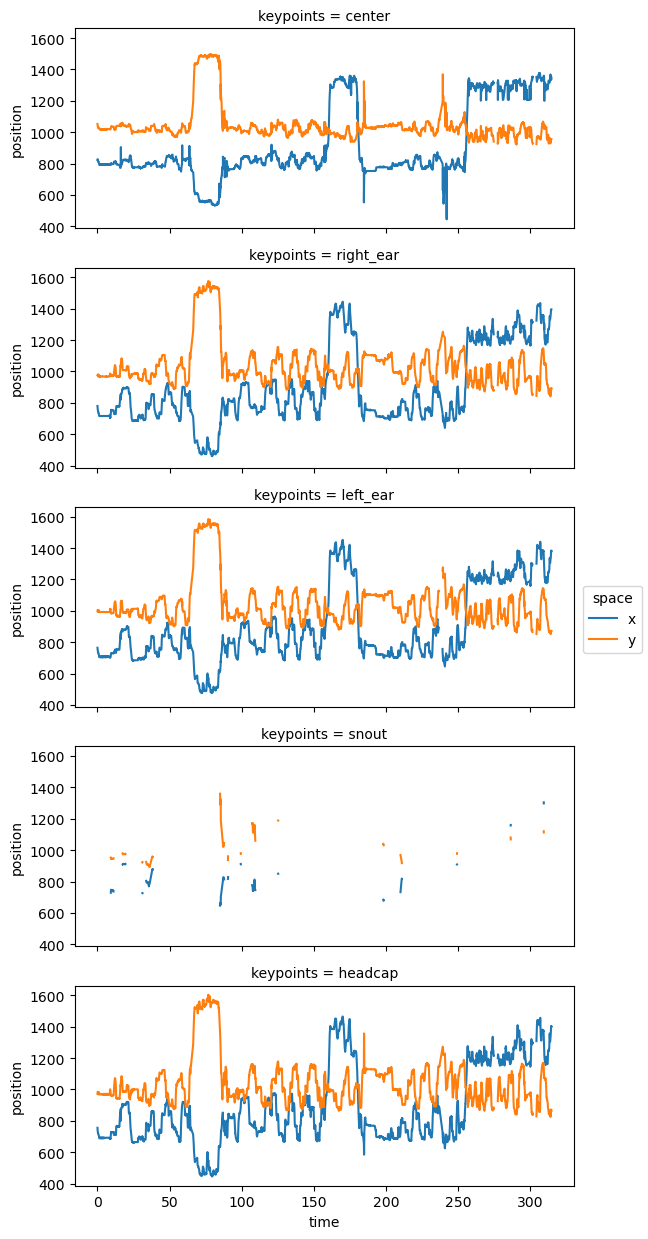

In [24]:
ds.update(
{
    "position": filter_by_confidence(
        ds.position, ds.confidence, print_report=True, threshold = 0.6
    )
}
)

# Interpolating over time
ds.update(
{
    "position": interpolate_over_time(
        ds.position, max_gap=70, print_report=True
    )
}
)

ds.position.squeeze().plot.line(
x="time", row="keypoints", hue="space", aspect=2, size=2.5
)